In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 原始数据路径
original_data_dir = "dataset"
# 目标路径
base_dir = "split_dataset"
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# 创建子目录
for split_dir in [train_dir, val_dir, test_dir]:
    for class_name in os.listdir(original_data_dir):
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# 遍历每个类别划分
for class_name in os.listdir(original_data_dir):
    class_dir = os.path.join(original_data_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    
    # 获取该类所有图片路径
    images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 第一次划分：训练+临时（80%），测试（20%）
    train_temp, test = train_test_split(images, test_size=0.2, random_state=42)
    
    # 第二次划分：训练（87.5% of 80% = 70%），验证（12.5% of 80% = 10%）
    train, val = train_test_split(train_temp, test_size=0.125, random_state=42)
    
    # 复制文件到目标目录
    def copy_files(file_list, target_dir):
        for f in file_list:
            shutil.copy(f, os.path.join(target_dir, class_name, os.path.basename(f)))
    
    
    copy_files(train, train_dir)
    copy_files(val, val_dir)
    copy_files(test, test_dir)

print("划分完成！")

划分完成！


In [25]:
# 执行后检查每个类别的数量

def count_files(path):
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        num_files = len(os.listdir(class_path))
        print(f"{class_name}: {num_files}")

print("训练集：")
count_files(train_dir)
print("\n验证集：")
count_files(val_dir)
print("\n测试集：")
count_files(test_dir)

训练集：
03: 31
04: 29
05: 31
02: 26
.DS_Store: 0
11: 31
10: 32
07: 28
09: 24
08: 33
01: 30
06: 28
12: 25

验证集：
03: 5
04: 5
05: 5
02: 4
.DS_Store: 0
11: 5
10: 5
07: 5
09: 4
08: 5
01: 5
06: 4
12: 4

测试集：
03: 9
04: 9
05: 10
02: 8
.DS_Store: 0
11: 10
10: 10
07: 9
09: 8
08: 10
01: 9
06: 8
12: 8


In [40]:
# 数据处理 归一化
from torchvision import transforms


# 训练集增强策略
train_transform = transforms.Compose([
    transforms.RandomRotation(15),      # 随机旋转±15度
    transforms.RandomHorizontalFlip(p=0.5),  # 50%概率水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 亮度对比度调整
    transforms.Resize((224, 224)),      # 缩放
    transforms.ToTensor(),              # 转为张量
    transforms.Normalize(               # ImageNet标准归一化
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 验证/测试集预处理（无需增强）
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [42]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# def remove_ds_store_files(folder_path):
#     """
#     递归遍历folder_path及其子文件夹，删除所有的 .DS_Store 文件
#     """
#     for root, dirs, files in os.walk(folder_path):
#         for filename in files:
#             if filename == '.DS_Store':
#                 file_path = os.path.join(root, filename)
#                 print(f"Removing {file_path}")
#                 os.remove(file_path)

# 在加载 ImageFolder 之前，先删除 ds_store
# remove_ds_store_files(train_dir)
# remove_ds_store_files(val_dir)
# remove_ds_store_files(test_dir)
# 加载划分后的数据集
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=test_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 查看类别标签映射
class_names = train_dataset.classes
print("类别对应关系:", class_names)

类别对应关系: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


In [43]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [44]:
import torchvision.models as models

# 加载预训练模型MobileNetV3
model = models.mobilenet_v3_small(pretrained=True)

# 冻结所有卷积层（可选，小数据集时推荐）
for param in model.features.parameters():
    param.requires_grad = False

# 修改分类头
num_classes = 12
model.classifier[3] = torch.nn.Linear(
    model.classifier[3].in_features,  # 保持输入维度不变
    num_classes                      # 输出12个类别
)


In [45]:
# 定义损失函数和优化器
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  # 只优化未冻结参数
    lr=0.001,
    weight_decay=1e-5
)


In [46]:
#学习率优化  (可选)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',     # 监控验证损失
    factor=0.1,     # 学习率乘以0.1
    patience=3,     # 连续3个epoch无改善触发
    verbose=True
)

In [47]:
# 定义训练函数

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 统计指标
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [48]:
# 定义验证函数

def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [49]:
# 开始训练

num_epochs = 30
best_val_acc = 0.0

for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    
    # 验证阶段
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # 更新学习率
    scheduler.step(val_loss)
    
    # 打印进度
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("=> Saved new best model")

Epoch 1/30
Train Loss: 2.2422 | Acc: 25.00%
Val Loss: 2.2543 | Acc: 23.21%
=> Saved new best model
Epoch 2/30
Train Loss: 1.5757 | Acc: 56.61%
Val Loss: 1.9616 | Acc: 41.07%
=> Saved new best model
Epoch 3/30
Train Loss: 1.2576 | Acc: 63.79%
Val Loss: 1.8320 | Acc: 37.50%
Epoch 4/30
Train Loss: 0.9862 | Acc: 68.68%
Val Loss: 1.6556 | Acc: 41.07%
Epoch 5/30
Train Loss: 0.9411 | Acc: 69.83%
Val Loss: 1.5324 | Acc: 44.64%
=> Saved new best model
Epoch 6/30
Train Loss: 0.8407 | Acc: 74.14%
Val Loss: 1.5797 | Acc: 42.86%
Epoch 7/30
Train Loss: 0.6907 | Acc: 79.60%
Val Loss: 1.3786 | Acc: 53.57%
=> Saved new best model
Epoch 8/30
Train Loss: 0.6827 | Acc: 79.31%
Val Loss: 1.4144 | Acc: 58.93%
=> Saved new best model
Epoch 9/30
Train Loss: 0.6315 | Acc: 79.60%
Val Loss: 1.2496 | Acc: 62.50%
=> Saved new best model
Epoch 10/30
Train Loss: 0.6195 | Acc: 79.02%
Val Loss: 1.3622 | Acc: 53.57%
Epoch 11/30
Train Loss: 0.5597 | Acc: 82.76%
Val Loss: 1.1609 | Acc: 66.07%
=> Saved new best model
Epoch

In [50]:
#  测试集评估

model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.2f}%")

/var/folders/91/yz0zj2jd4v301gnxwb4mm4dw0000gn/T/ipykernel_89778/2264282637.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

Test Accuracy: 68.52%


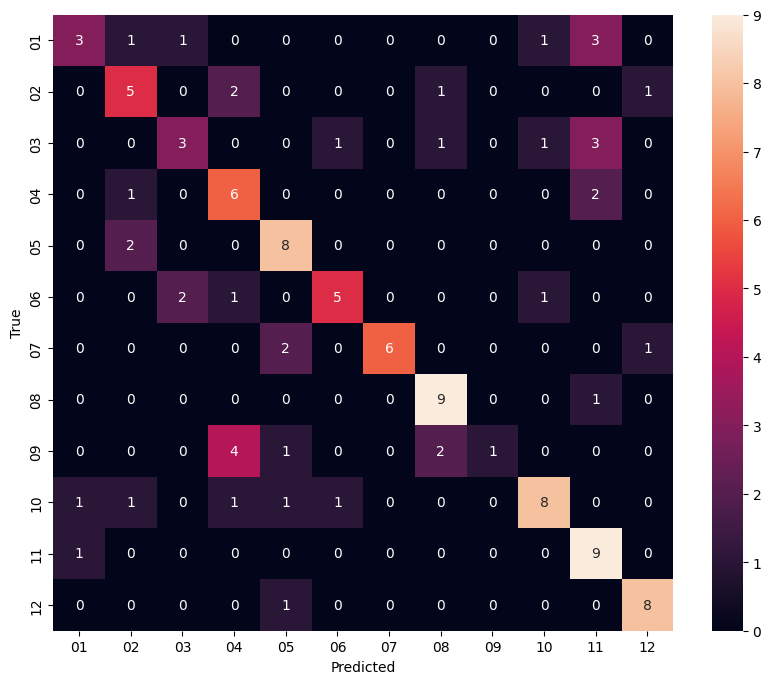

In [16]:
# 混淆矩阵 可视化(可选)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

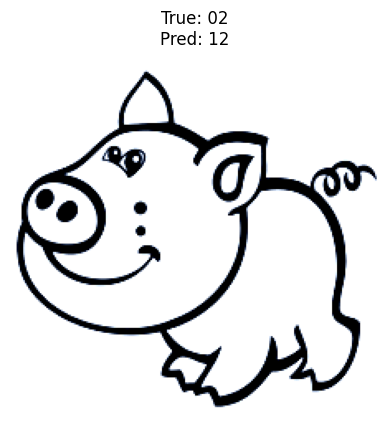

In [51]:
# 错误样本分析 (可选)


import numpy as np

# 随机查看错误样本
errors = np.where(np.array(all_preds) != np.array(all_labels))[0]
idx = np.random.choice(errors)
img, true_label = test_dataset[idx]
pred_label = all_preds[idx]

plt.imshow(img.permute(1,2,0).numpy() * 0.5 + 0.5)  # 反归一化
plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
plt.axis('off')

In [22]:
from PIL import Image

def predict(image_path):
    # 加载图像
    img = Image.open(image_path).convert('RGB')
    
    # 预处理
    transform = test_transform
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # 推理
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.nn.functional.softmax(output[0], dim=0)
    
    # 获取结果
    pred_idx = torch.argmax(prob).item()
    confidence = prob[pred_idx].item()
    return class_names[pred_idx], confidence

# 使用示例
label, conf = predict("test2.png")
print(f"Prediction: {label} ({conf*100:.1f}%)")

Prediction: 08 (96.6%)
